In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob

from utils.datasets.foscal.patient import FOSCALPatient
from utils.preprocessing.numpy import get_idxs_of_annotated_slices
from metrics import compute_segmentation_metrics
%matplotlib inline

normal_train_patients = ["ACV-107", "ACV-110", "ACV-128", "ACV-129", "ACV-140"]
normal_test_patients = ["ACV-149", "ACV-198"]

# Load the data

In [2]:
patients = []
patients_label = []
dset_dir = "/data/Datasets/stroke/MICCAI/test"
patient_dirs = sorted(glob(os.path.join(dset_dir, "*")))
for patient_dir in patient_dirs:
    patient = FOSCALPatient(patient_dir)
    patients.append(patient)
    # data = patient.get_data(modalities=["ADC", "DWI"])
    # adc, dwi = data["ADC"], data["DWI"]
    # print(f"ADC shape: {adc.shape}, DWI shape: {dwi.shape}")
    patients_label.append(patient_dir.split('/')[6][:])

# Visualize some cases

Text(0.5, 1.0, 'Andres DWI Mask')

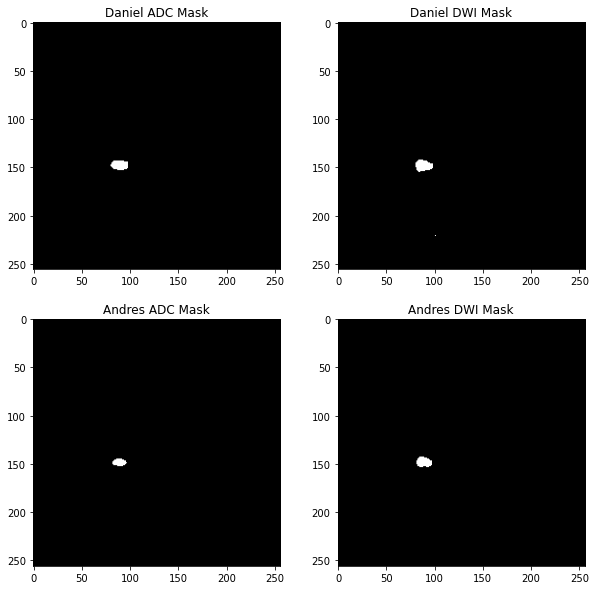

In [3]:
modalities = ["ADC", "DWI"]
normalization = "min_max"

modalities = ["ADC", "DWI"]
masks_daniel = patients[0].get_mask(modalities=modalities, radiologist="Daniel")
masks_andres = patients[0].get_mask(modalities=modalities, radiologist="Andres")

idxs_with_annotations = get_idxs_of_annotated_slices(masks_daniel["ADC"])
masks_daniel["ADC"] = masks_daniel["ADC"][..., idxs_with_annotations]
masks_daniel["DWI"] = masks_daniel["DWI"][..., idxs_with_annotations]
masks_andres["ADC"] = masks_andres["ADC"][..., idxs_with_annotations]
masks_andres["DWI"] = masks_andres["DWI"][..., idxs_with_annotations]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(masks_daniel["ADC"][..., 0], cmap="gray")
axs[0, 0].set_title("Daniel ADC Mask")
axs[0, 1].imshow(masks_daniel["DWI"][..., 0], cmap="gray")
axs[0, 1].set_title("Daniel DWI Mask")
axs[1, 0].imshow(masks_andres["ADC"][..., 0], cmap="gray")
axs[1, 0].set_title("Andres ADC Mask")
axs[1, 1].imshow(masks_andres["DWI"][..., 0], cmap="gray")
axs[1, 1].set_title("Andres DWI Mask")

Compute metrics example

In [6]:
data = patients[0].get_data(modalities=modalities, normalization=normalization)
masks = patients[0].get_mask(modalities=modalities)
compute_segmentation_metrics(masks["DWI"], masks["ADC"])

{'sens': 0.819767441292303,
 'spec': 0.9999936414758139,
 'ppv': 0.9337748336999031,
 'npv': 0.9999802888383836,
 'dsc': 0.8730689452338937,
 'avd': 0.13003095975232198,
 'hd': 68.3593446428504}

# Metrics

## Compute segmentation metrics

In [ ]:
metric_names = ['sens', 'spec', 'ppv', 'npv', 'dsc', 'avd', 'hd']
segmentation_metrics = {
    "r1_adc_dwi": {m: [] for m in metric_names},
    "r2_adc_dwi": {m: [] for m in metric_names},
    "r1_r2_adc": {m: [] for m in metric_names},
    "r1_r2_dwi": {m: [] for m in metric_names},
}

for patient in tqdm(patients, desc="Processing patients"):
    andres_masks = patient.get_mask(radiologist="Andres")
    daniel_masks = patient.get_mask(radiologist="Daniel")

    adc_andres, dwi_andres = andres_masks["ADC"], andres_masks["DWI"]
    adc_daniel, dwi_daniel = daniel_masks["ADC"], daniel_masks["DWI"]

    # ADC vs DWI same radiologist.
    andres_adc_dwi = compute_segmentation_metrics(adc_andres, dwi_andres)
    daniel_adc_dwi = compute_segmentation_metrics(adc_daniel, dwi_daniel)

    # Different radiologists ADC.
    andres_daniel_adc = compute_segmentation_metrics(adc_andres, adc_daniel)

    # Different radiologists DWI.
    andres_daniel_dwi = compute_segmentation_metrics(dwi_andres, dwi_daniel)

    for m in metric_names:
        segmentation_metrics["r1_adc_dwi"][m].append(andres_adc_dwi[m])
        segmentation_metrics["r2_adc_dwi"][m].append(daniel_adc_dwi[m])
        segmentation_metrics["r1_r2_adc"][m].append(andres_daniel_adc[m])
        segmentation_metrics["r1_r2_dwi"][m].append(andres_daniel_dwi[m])
    
    # break

segmentation_metrics

Processing patients:   0%|          | 0/31 [00:00<?, ?it/s]

In [ ]:
segmentation_metrics.keys()

In [ ]:
for measure in segmentation_metrics:
    for metric_name in ["dsc", "ppv", "sens"]:
        print(
            f"{measure} - {metric_name}: "
            f"{np.nanmean(segmentation_metrics[measure][metric_name]):.3f}")
    print("------")        


# Agreement between radiologists using ADC masks

In [4]:
def get_agreements(modality):

    Kappas = []
    category = []
    experiments = []
    patients_plot = []
    
    for idx_p, patient in enumerate(patients):
        patients_plot.append(patients_label[idx_p])
        masks_daniel = np.expand_dims(patient.get_mask(modalities=[modality], radiologist="Daniel")[modality], axis=2)
        masks_andres = np.expand_dims(patient.get_mask(modalities=[modality], radiologist="Andres")[modality], axis=2)

        dims = np.shape(masks_daniel)
        total = dims[0]*dims[1]*dims[2]*dims[3]

        andres_0 = np.sum(masks_andres == 0)
        daniel_0 = np.sum(masks_daniel == 0)
        andres_1 = np.sum(masks_andres == 1)
        daniel_1 = np.sum(masks_daniel == 1)

        andres_daniel_0 = np.sum(np.sum(np.concatenate((masks_andres == 0, masks_daniel == 0), axis=2), axis=2) == 2)
        andres_daniel_1 = np.sum(np.sum(np.concatenate((masks_andres == 1, masks_daniel == 1), axis=2), axis=2) == 2)
        
        if andres_daniel_0 == total:
            kappa = 1.
        else:
            p_0  = (andres_daniel_0 + andres_daniel_1)/total
            si_a = (andres_1/total) * (daniel_1/total)
            no_a = (andres_0/total) * (daniel_0/total)
            p_e  = si_a + no_a
            kappa = (p_0 - p_e)/(1 - p_e)

        Kappas.append(round(kappa, 5))

        if kappa <0.1:
            category.append('No')
        elif 0.1<=kappa<0.2:
            category.append('Slight')
        elif 0.2<=kappa<0.4:
            category.append('Fair')
        elif 0.4<=kappa<0.6:
            category.append('Moderate')
        elif 0.6<=kappa<0.8:
            category.append('Substantial')
        elif 0.8<=kappa<1.1:
            category.append('Near perfect')
        
        experiments.append(modality)


        print("--------------------------------")
        print(patients_label[idx_p])
        print(masks_daniel.shape, masks_andres.shape)
        print(andres_daniel_1, andres_daniel_0)
        print(andres_0, andres_1)
        print(daniel_0, daniel_1)
        print(total)
        print(p_0)
        print(p_e)
        print(kappa)
        print("--------------------------------")

    #print("kappa primedio:",np.mean(Kappas))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle("ADC vs ADC average kappa:{}".format(round(np.mean(Kappas), 2)))

    g = sns.barplot(data={'Kappa':Kappas, 'Patient': patients_plot, 'Category': category}, x='Patient', y='Kappa', ax=ax1, color= "mediumpurple")

    for idx, container in enumerate(g.containers):
        g.bar_label(container,rotation=90)

    ax1.grid(0.3)
    ax1.set_ylim(0, 1)
    ax1.set_xticklabels(patients_plot, rotation=90)

    data = [np.sum(np.array(category) == i) for i in np.unique(category)]
    labels = np.unique(category)
    colors = sns.color_palette("Blues")
    ax2.pie(data, labels=labels, colors = colors, autopct = '%0.0f%%')

    return Kappas, category, experiments, patients_plot
    

--------------------------------
ACV-145
(256, 256, 1, 24) (256, 256, 1, 24)
90 1572679
1572740 124
1572713 151
1572864
0.9999396006266276
0.9998251748458846
0.6545155433835798
--------------------------------
--------------------------------
ACV-149
(256, 256, 1, 24) (256, 256, 1, 24)
0 1572864
1572864 0
1572864 0
1572864
0.9999396006266276
0.9998251748458846
1.0
--------------------------------
--------------------------------
ACV-150
(256, 256, 1, 26) (256, 256, 1, 26)
235 1703187
1703487 449
1703401 535
1703936
0.9996983454777644
0.999422678993271
0.477492558352005
--------------------------------
--------------------------------
ACV-151
(256, 256, 1, 24) (256, 256, 1, 24)
298 1572205
1572284 580
1572487 377
1572864
0.9997704823811849
0.9993917325595651
0.6226698922911527
--------------------------------
--------------------------------
ACV-159
(256, 256, 1, 26) (256, 256, 1, 26)
3086 1697621
1699378 4558
1699093 4843
1703936
0.998104975773738
0.9944979799043431
0.6555766439752131


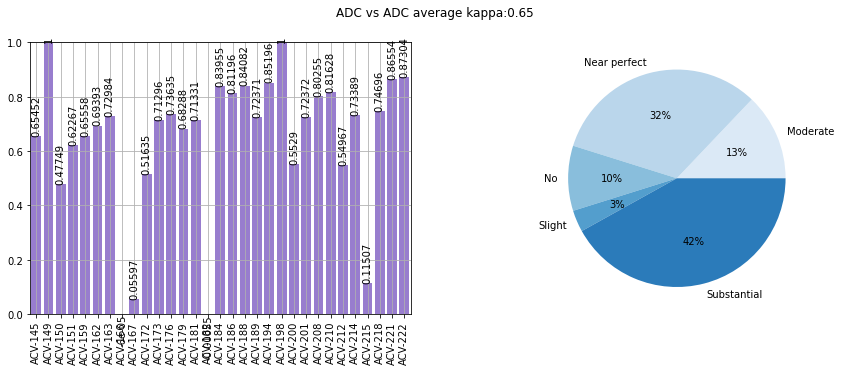

In [5]:
Kappas_ADC, category_ADC, experiments_ADC, patients_plot_ADC = get_agreements('ADC')

# Agreement between radiologists using DWI masks

--------------------------------
ACV-145
(256, 256, 1, 24) (256, 256, 1, 24)
137 1572647
1572682 182
1572692 172
1572864
0.9999491373697916
0.9997749581687256
0.7739858855558273
--------------------------------
--------------------------------
ACV-149
(256, 256, 1, 24) (256, 256, 1, 24)
0 1572864
1572864 0
1572864 0
1572864
0.9999491373697916
0.9997749581687256
1.0
--------------------------------
--------------------------------
ACV-150
(256, 256, 1, 26) (256, 256, 1, 26)
350 1703155
1703454 482
1703287 649
1703936
0.999747056227464
0.9993364581598532
0.6187975539265642
--------------------------------
--------------------------------
ACV-151
(256, 256, 1, 24) (256, 256, 1, 24)
379 1571711
1572081 783
1572115 749
1572864
0.9995079040527344
0.9990264547547364
0.49453202133160234
--------------------------------
--------------------------------
ACV-159
(256, 256, 1, 26) (256, 256, 1, 26)
4263 1696253
1698318 5618
1697608 6328
1703936
0.9979928823617789
0.9930136623356999
0.7127081835054

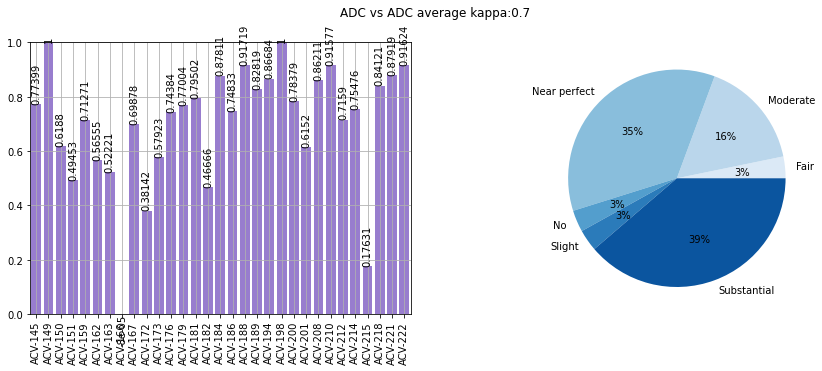

In [6]:
Kappas_DWI, category_DWI, experiments_DWI, patients_plot_DWI = get_agreements('DWI')

# Agreement between ADC and DWI masks of the same radiologist

In [16]:
def get_agreements_adc_dwi(person):

    Kappas = []
    category = []
    experiments = []
    patients_plot = []
    for idx_p, patient in enumerate(patients):
        masks_ADC = np.expand_dims(patient.get_mask(modalities=['ADC'], radiologist=person)['ADC'], axis=2)
        masks_DWI = np.expand_dims(patient.get_mask(modalities=['DWI'], radiologist=person)['DWI'], axis=2)
        
        print(patients_label[idx_p])
        print(masks_ADC.shape, masks_DWI.shape)
            
        if len(masks_DWI.shape)<5:
            patients_plot.append(patients_label[idx_p])

            dims = np.shape(masks_ADC)
            total = dims[0]*dims[1]*dims[2]*dims[3]

            ADC_0 = np.sum(masks_ADC == 0)
            DWI_0 = np.sum(masks_DWI == 0)
            ADC_1 = np.sum(masks_ADC == 1)
            DWI_1 = np.sum(masks_DWI == 1)

            ADC_DWI_0 = np.sum(np.sum(np.concatenate((masks_ADC == 0, masks_DWI == 0), axis=2), axis=2) == 2)
            ADC_DWI_1 = np.sum(np.sum(np.concatenate((masks_ADC == 1, masks_DWI == 1), axis=2), axis=2) == 2)
            
            if ADC_DWI_0 == total:
                kappa = 1.
            else:
                p_0  = (ADC_DWI_0 + ADC_DWI_1)/total
                si_a = (ADC_1/total) * (DWI_1/total)
                no_a = (ADC_0/total) * (DWI_0/total)
                p_e  = si_a + no_a
                kappa = (p_0 - p_e)/(1 - p_e)

            Kappas.append(round(kappa, 2))

            if kappa <0.1:
                category.append('No')
            elif 0.1<=kappa<0.2:
                category.append('Slight')
            elif 0.2<=kappa<0.4:
                category.append('Fair')
            elif 0.4<=kappa<0.6:
                category.append('Moderate')
            elif 0.6<=kappa<0.8:
                category.append('Substantial')
            elif 0.8<=kappa<1.1:
                category.append('Near perfect')

            experiments.append('ADC vs DWI')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle("ADC vs DWI average kappa:{}".format(round(np.mean(Kappas), 2)))

    g = sns.barplot(data={'Kappa':Kappas, 'Patient': patients_plot, 'Category': category}, x='Patient', y='Kappa', ax=ax1, color= "mediumpurple")

    for idx, container in enumerate(g.containers):
        g.bar_label(container,rotation=90)

    ax1.grid(0.3)
    ax1.set_ylim(0, 1)
    ax1.set_xticklabels(patients_plot, rotation=90)

    data = [np.sum(np.array(category) == i) for i in np.unique(category)]
    labels = np.unique(category)
    
    sns.color_palette("rocket")

    colors = sns.color_palette("Blues")
    ax2.pie(data, labels=labels, colors = colors, autopct = '%0.0f%%')

    return Kappas, category, experiments, patients_plot

ACV-145
(256, 256, 1, 24) (256, 256, 1, 24)
ACV-149
(256, 256, 1, 24) (256, 256, 1, 24)
ACV-150
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-151
(256, 256, 1, 24) (256, 256, 1, 24)
ACV-159
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-162
(256, 256, 1, 24) (256, 256, 1, 24)
ACV-163
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-166
(256, 256, 1, 24) (256, 256, 1, 24)
ACV-167
(288, 288, 1, 23) (288, 288, 1, 23)
ACV-172
(300, 288, 1, 20) (300, 288, 1, 20)
ACV-173
(256, 256, 1, 24) (256, 256, 1, 24)
ACV-176
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-179
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-181
(256, 256, 1, 24) (256, 256, 1, 24)
ACV-182
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-184
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-186
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-188
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-189
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-194
(256, 256, 1, 24) (256, 256, 1, 24)
ACV-198
(256, 256, 1, 26) (256, 256, 1, 26)
ACV-200
(256, 256, 1, 24) (256, 256, 1, 24)
ACV-201
(256, 256, 1, 24) (256, 

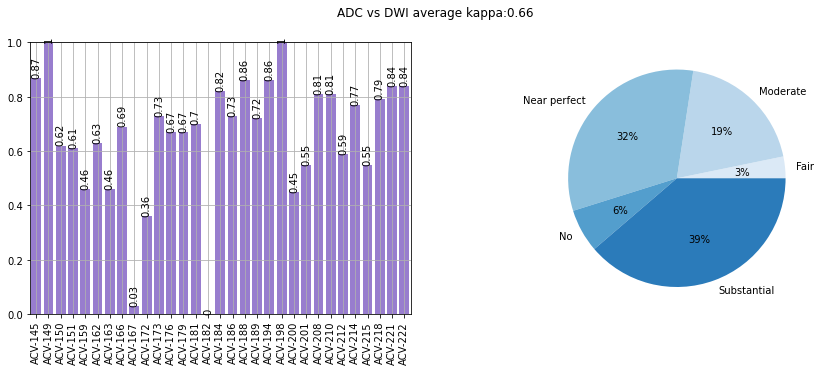

In [17]:
Kappas_ADC_DWI, category_ADC_DWI, experiments_ADC_DWI, patients_plot_ADC_DWI = [], [], [], []
Kappas, category, experiments, patients_plot = get_agreements_adc_dwi('Daniel')
Kappas_ADC_DWI += Kappas
category_ADC_DWI += category
experiments_ADC_DWI += experiments
patients_plot_ADC_DWI += patients_plot


In [18]:
print(len(Kappas_ADC_DWI), len(category_ADC_DWI), len(experiments_ADC_DWI))

31 31 31


In [19]:
print(len(Kappas_ADC), len(category_ADC), len(experiments_ADC))

31 31 31


In [20]:
print(len(Kappas_DWI), len(category_DWI), len(experiments_DWI))

31 31 31


In [21]:
kappas = []
category = []
experiments = []
patients_string = []

In [22]:
kappas += Kappas_ADC_DWI + Kappas_ADC + Kappas_DWI
category += category_ADC_DWI + category_ADC + category_DWI
experiments += experiments_ADC_DWI + experiments_ADC + experiments_DWI
patients_string += patients_plot_ADC_DWI + patients_plot_ADC + patients_plot_DWI

data_plot = pd.DataFrame({'Kappa value':kappas, 'Patients': patients_string, 'Category': category, 'Modality': experiments})
data_plot

,Kappa value,Patients,Category,Modality
0,0.87000,ACV-145,Near perfect,ADC vs DWI
1,1.00000,ACV-149,Near perfect,ADC vs DWI
2,0.62000,ACV-150,Substantial,ADC vs DWI
3,0.61000,ACV-151,Substantial,ADC vs DWI
4,0.46000,ACV-159,Moderate,ADC vs DWI
...,...,...,...,...
88,0.75476,ACV-214,Substantial,DWI
89,0.17631,ACV-215,Slight,DWI
90,0.84121,ACV-218,Near perfect,DWI
91,0.87919,ACV-221,Near perfect,DWI


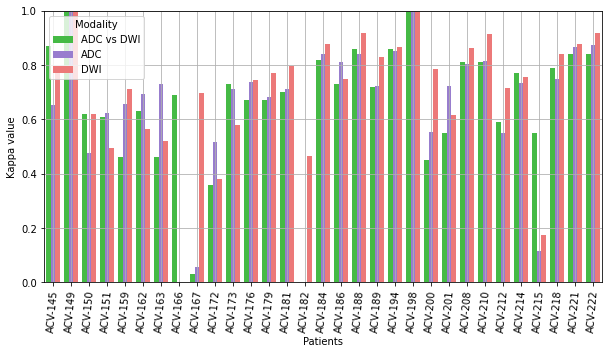

In [23]:
plt.figure(figsize=(10, 5))

g = sns.barplot(data=data_plot, x='Patients', y='Kappa value', hue='Modality', palette=['limegreen', "mediumpurple", '#FF6666'])

"""for idx, container in enumerate(g.containers):
    g.bar_label(container,rotation=90)"""

plt.grid(0.3)
plt.ylim(0, 1)
plt.xticks(rotation = 85)
plt.savefig('Agreements.pdf', bbox_inches='tight')

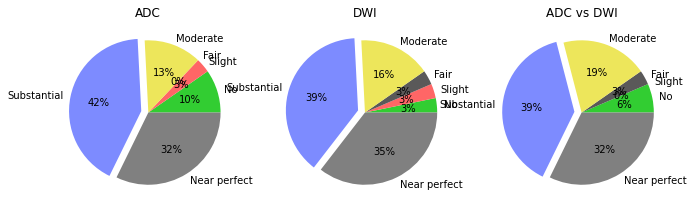

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5))

data_plot_pie = data_plot[data_plot['Modality'] == 'ADC']
category_pie = data_plot_pie['Category'].values

labels = ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
explode = (0, 0, 0, 0, 0.1, 0) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#FF6666', '#5A5959', '#EDE65B', '#7D8BFF', 'gray']
ax1.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
ax1.set_title('ADC')

data_plot_pie = data_plot[data_plot['Modality'] == 'DWI']
category_pie = data_plot_pie['Category'].values

labels = ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
explode = (0, 0, 0, 0, 0.1, 0) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#FF6666', '#5A5959', '#EDE65B', '#7D8BFF', 'gray']
ax2.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
ax2.set_title('DWI')

data_plot_pie = data_plot[data_plot['Modality'] == 'ADC vs DWI']
category_pie = data_plot_pie['Category'].values

labels = ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
explode = (0, 0, 0, 0, 0.1, 0) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#FF6666', '#5A5959', '#EDE65B', '#7D8BFF', 'gray']
ax3.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
ax3.set_title('ADC vs DWI')

#plt.legend(labels)
plt.savefig('Pie_agreement.pdf', bbox_inches='tight')


In [53]:
labels = []
data   = []
modal  = []

data_plot_pie = data_plot[data_plot['Modality'] == 'ADC']
category_pie  = data_plot_pie['Category'].values
total         = len(category_pie)

labels += ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
data   += [round(np.sum(np.array(category_pie) == i)/total, 3) for i in ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']]
modal  += ['A) ADC' for i in ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']]

data_plot_pie = data_plot[data_plot['Modality'] == 'DWI']
category_pie = data_plot_pie['Category'].values
total         = len(category_pie)

labels += ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
data   += [round(np.sum(np.array(category_pie) == i)/total, 3) for i in ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']]
modal  += ['B) DWI' for i in ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']]

data_plot_pie = data_plot[data_plot['Modality'] == 'ADC vs DWI']
category_pie = data_plot_pie['Category'].values
total         = len(category_pie)

labels += ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
data   += [round(np.sum(np.array(category_pie) == i)/total, 3) for i in ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']]
modal  += ['C) ADC vs DWI' for i in ['No', 'Slight', 'Fair', 'Moderate', 'Substantial', 'Near perfect']]

print(len(data), len(labels), len(modal))

plot_pandas = pd.DataFrame({'Samples':[val * 100 for val in data], 'Levels':labels, 'Modalities': modal})


18 18 18


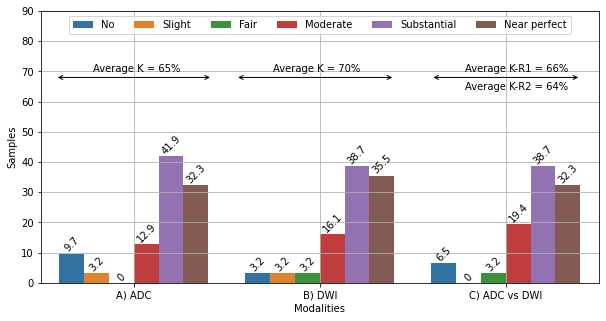

In [55]:
plt.figure(figsize=(10,5))
g = sns.barplot(data=plot_pandas, x='Modalities', y='Samples', hue='Levels')
for idx, container in enumerate(g.containers):
        g.bar_label(container,rotation=45)
plt.grid()

plt.annotate(text='', xy=(-0.42,68), xytext=(0.42,68), arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='Average K = 65%', xy=(-0.22,70))

plt.annotate(text='', xy=(0.55,68), xytext=(1.4,68), arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='Average K = 70%', xy=(0.75,70))

plt.annotate(text='', xy=(1.6,68), xytext=(2.4,68), arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='Average K-R1 = 66%', xy=(1.78,70))
plt.annotate(text='Average K-R2 = 64%', xy=(1.78,64))

plt.ylim(0, 90)
plt.legend(loc='upper center', ncol = 6)

plt.savefig('agreement.pdf', bbox_inches='tight')

ValueError: 'explode' must be of length 'x'

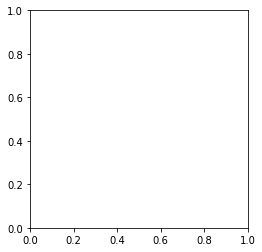

In [132]:
data_plot_pie = data_plot[data_plot['Modality'] == 'DWI']
category_pie = data_plot_pie['Category'].values

labels = ['No', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#FF6666', '#5A5959', '#EDE65B', '#7D8BFF']
plt.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
plt.title('ADC')
plt.savefig('ADC_agreement.pdf', bbox_inches='tight')

In [ ]:
data_plot_pie = data_plot[data_plot['Modality'] == 'DWI']
category_pie = data_plot_pie['Category'].values
labels = ['No', 'Moderate', 'Substantial', 'Near perfect']
explode = (0, 0, 0, 0.1) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#5A5959', '#EDE65B', '#7D8BFF']
plt.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
plt.title('DWI')
plt.savefig('DWI_agreement.pdf', bbox_inches='tight')

In [ ]:
data_plot_pie = data_plot[data_plot['Modality'] == 'ADC vs DWI']
category_pie = data_plot_pie['Category'].values
labels = ['No', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
explode = (0.1, 0, 0, 0, 0) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#FF6666', '#5A5959', '#EDE65B', '#7D8BFF']
plt.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
plt.title('ADC vs DWI')
plt.savefig('ADC_DWI_agreement.pdf', bbox_inches='tight')